# 6 - Transformers for Sentiment Analysis

In this notebook we will be using the transformer model, first introduced in [this](https://arxiv.org/abs/1706.03762) paper. Specifically, we will be using the BERT (Bidirectional Encoder Representations from Transformers) model from [this](https://arxiv.org/abs/1810.04805) paper. 

Transformer models are considerably larger than anything else covered in these tutorials. As such we are going to use the [transformers library](https://github.com/huggingface/transformers) to get pre-trained transformers and use them as our embedding layers. We will freeze (not train) the transformer and only train the remainder of the model which learns from the representations produced by the transformer. In this case we will be using a multi-layer bi-directional GRU, however any model can learn from these representations.

## Preparing Data

First, as always, let's set the random seeds for deterministic results.

In [ ]:
import torch

import random
import numpy as np

SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
!pip install keras==2.3.1
!pip install tensorflow==2.1.0
!pip install plot_keras_history
!pip install h5py==2.10.0
!pip install plot_keras_history
!pip install transformers

## Import

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 15 21:39:26 2020

@author: isswan
"""
from __future__ import print_function

import pandas as pd
import numpy as np

from keras import layers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D,Reshape, Dense, Dropout, Flatten, MaxPooling1D, Input, Concatenate, LSTM, Bidirectional
from keras.models import load_model
from keras.models import Model

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn import metrics 

import joblib

import matplotlib.pyplot as plt
from plot_keras_history import plot_history
import tensorflow as tf
from tensorflow.keras.utils import plot_model

import pickle

import transformers

import torch


Using TensorFlow backend.


# ESCONV Classifier - Categories


## Data - ESConv.json

In [ ]:
data = pd.read_json("ESConv.json")
data.head()

,experience_type,emotion_type,problem_type,situation,survey_score,dialog,seeker_question1,seeker_question2,supporter_question1,supporter_question2
0,Previous Experience,anxiety,job crisis,I hate my job but I am scared to quit and seek...,"{'seeker': {'initial_emotion_intensity': '5', ...","[{'speaker': 'seeker', 'annotation': {}, 'cont...",Partner was very supportive,More guidance in conversation or examples,,
1,Current Experience,anger,problems with friends,I have complete unsupportive friends its to th...,"{'seeker': {'initial_emotion_intensity': '5', ...","[{'speaker': 'supporter', 'annotation': {'stra...",,,It was simple,The middle screen hover function gets in the way
2,Current Experience,fear,job crisis,I have been out of work for five weeks in quar...,"{'seeker': {'initial_emotion_intensity': '4', ...","[{'speaker': 'supporter', 'annotation': {'stra...",no,no,,
3,Current Experience,depression,ongoing depression,I am depressed staying home due to COVID,"{'seeker': {'initial_emotion_intensity': '4', ...","[{'speaker': 'supporter', 'annotation': {'stra...",No,No,,
4,Current Experience,depression,breakup with partner,I found out that my boyfriend had been lying t...,"{'seeker': {'initial_emotion_intensity': '5', ...","[{'speaker': 'supporter', 'annotation': {'stra...",Good exercise,no,,


## Label for Classification

In [ ]:
# dict(data.loc[data['problem_type']=='academic pressure', 'problem_type']).keys()

data.loc[data['problem_type']=='School Bullying', 'problem_type'] = "school" #965, 1003
data.loc[data['problem_type']=='academic pressure', 'problem_type'] = "school"

data.loc[data['problem_type']=='problems with friends', 'problem_type'] = "friendship"

data.loc[data['problem_type']=='job crisis', 'problem_type'] = "work"

data.loc[data['problem_type']=='breakup with partner', 'problem_type'] = "relationship"

data.loc[data['problem_type']=='conflict with parents', 'problem_type'] = "family"
data.loc[data['problem_type']=='Issues with Children', 'problem_type'] = "family"
data.loc[data['problem_type']=='Issues with Parents', 'problem_type'] = "family"

data.loc[data['problem_type']=='ongoing depression', 'problem_type'] = "emotional"
data.loc[data['problem_type']=='Appearance Anxiety', 'problem_type'] = "emotional"

data.loc[data['problem_type']=='Sleep Problems', 'problem_type'] = "others"
data.loc[data['problem_type']=='Procrastination', 'problem_type'] = "others"
data.loc[data['problem_type']=='Alcohol Abuse', 'problem_type'] = "others"

display(data.problem_type.value_counts())

labels = set(data.problem_type.values)
labels

emotional       363
work            280
relationship    239
friendship      179
school          158
others           53
family           28
Name: problem_type, dtype: int64

{'emotional',
 'family',
 'friendship',
 'others',
 'relationship',
 'school',
 'work'}

In [ ]:
newdata = data[['situation', 'problem_type']]
newdata.to_csv("newdata.csv")


In [ ]:
#Data Preprocessing 
y = data['problem_type']
X = data['situation']
length = data['situation'].apply(len)
data = data.assign(Len_Situation=length)

#Split train & test
text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
text_train

1143    I made a mistake at work and I feel I might ge...
1053    Husband of 9 years walked out on me and our ch...
372     My boss recently left the company and I am not...
826     my boss does not care about my and there is no...
840                                          I was fired.
                              ...                        
715     I am always in the mood of depression. I thoug...
905     thinking about what classes are best to take i...
1096            I did not study and did poorly on a test.
235     I don't have any friends. People keep betrayin...
1061    My partner is abusing me for not earning money...
Name: situation, Length: 910, dtype: object

In [ ]:
print(type(text_train))

<class 'pandas.core.series.Series'>


In [ ]:
train_ = pd.concat([text_train, y_train], axis=1)
train_.to_csv("train_.csv")
test_ = pd.concat([text_test, y_test], axis=1)
test_.to_csv("test_.csv")

# Using BERT to do classification

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
tokens = tokenizer.tokenize('I have a bad day')

print(tokens)

['i', 'have', 'a', 'bad', 'day']


We can numericalize tokens using our vocabulary using `tokenizer.convert_tokens_to_ids`.

In [ ]:
indexes = tokenizer.convert_tokens_to_ids(tokens)

print(indexes)

[1045, 2031, 1037, 2919, 2154]


In [ ]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

[CLS] [SEP] [PAD] [UNK]


We can get the indexes of the special tokens by converting them using the vocabulary...

In [ ]:
init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


In [ ]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

print(max_input_length)

512


In [ ]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

In [ ]:
from torchtext.legacy.data import Field
from torchtext.legacy.data import TabularDataset
from torchtext.legacy.data import Iterator
from torchtext.legacy.data import LabelField, BucketIterator

In [ ]:
TEXT = Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

LABEL = LabelField()

We load the data and create the validation splits as before.

In [ ]:
from torchtext.legacy import datasets

train_data, valid_data = TabularDataset.splits(
            path='./',
            format='csv',
            train = 'train_.csv',
            validation = 'test_.csv',
            skip_header=True,
            fields=[('ID',None),  ('text', TEXT), ('label', LABEL)],
        )

In [ ]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")


Number of training examples: 910
Number of validation examples: 390


In [ ]:
test_data = TabularDataset(
            path='newdata.csv',
            format='csv',
            skip_header=True,
            fields=[('ID',None),  ('text', TEXT), ('label', LABEL)],
        )

We can check an example and ensure that the text has already been numericalized.

In [ ]:
print(vars(test_data.examples[29]))

{'text': [2026, 2879, 2767, 2187, 2033, 2005, 2498, 1010, 1045, 2699, 2000, 3198, 2005, 7526, 2021, 1045, 2180, 1005, 1056, 2131, 2151, 2518, 1010, 2191, 2033, 14777, 1998, 2371, 2894, 1012], 'label': 'relationship'}


In [ ]:
print(vars(train_data.examples[6]))

{'text': [1045, 3728, 3631, 2039, 2007, 2026, 6898, 1998, 1045, 1005, 1049, 2383, 1037, 2524, 2051, 2138, 2009, 1005, 1055, 2471, 1996, 11938, 1012], 'label': 'relationship'}


We can use the `convert_ids_to_tokens` to transform these indexes back into readable tokens.

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(vars(train_data.examples[6])['text'])

print(tokens)

['i', 'recently', 'broke', 'up', 'with', 'my', 'boyfriend', 'and', 'i', "'", 'm', 'having', 'a', 'hard', 'time', 'because', 'it', "'", 's', 'almost', 'the', 'holidays', '.']


Although we've handled the vocabulary for the text, we still need to build the vocabulary for the labels.

In [ ]:
LABEL.build_vocab(train_data)

In [ ]:
print(LABEL.vocab.stoi)

defaultdict(None, {'emotional': 0, 'work': 1, 'relationship': 2, 'friendship': 3, 'school': 4, 'others': 5, 'family': 6})


As before, we create the iterators. Ideally we want to use the largest batch size that we can as I've found this gives the best results for transformers.

In [ ]:
BATCH_SIZE = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    sort=False,
    batch_size = BATCH_SIZE, 
    device = device)

## Build the Model

Next, we'll load the pre-trained model, making sure to load the same model as we did for the tokenizer.

In [ ]:
from transformers import BertTokenizer, BertModel

bert = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Next, we'll define our actual model. 

Instead of using an embedding layer to get embeddings for our text, we'll be using the pre-trained transformer model. These embeddings will then be fed into a GRU to produce a prediction for the sentiment of the input sentence. We get the embedding dimension size (called the `hidden_size`) from the transformer via its config attribute. The rest of the initialization is standard.

Within the forward pass, we wrap the transformer in a `no_grad` to ensure no gradients are calculated over this part of the model. The transformer actually returns the embeddings for the whole sequence as well as a *pooled* output. The [documentation](https://huggingface.co/transformers/model_doc/bert.html#transformers.BertModel) states that the pooled output is "usually not a good summary of the semantic content of the input, you’re often better with averaging or pooling the sequence of hidden-states for the whole input sequence", hence we will not be using it. The rest of the forward pass is the standard implementation of a recurrent model, where we take the hidden state over the final time-step, and pass it through a linear layer to get our predictions.

In [ ]:
import torch.nn as nn

class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(text)[0]
                
        #embedded = [batch size, sent len, emb dim]
        
        _, hidden = self.rnn(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output

Next, we create an instance of our model using standard hyperparameters.

In [ ]:
HIDDEN_DIM = 256
OUTPUT_DIM = 7
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

model = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

We can check how many parameters the model has. Our standard models have under 5M, but this one has 112M! Luckily, 110M of these parameters are from the transformer and we will not be training those.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 112,244,487 trainable parameters


In order to freeze paramers (not train them) we need to set their `requires_grad` attribute to `False`. To do this, we simply loop through all of the `named_parameters` in our model and if they're a part of the `bert` transformer model, we set `requires_grad = False`. 

In [ ]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

We can now see that our model has under 3M trainable parameters, making it almost comparable to the `FastText` model. However, the text still has to propagate through the transformer which causes training to take considerably longer.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,762,247 trainable parameters


We can double check the names of the trainable parameters, ensuring they make sense. As we can see, they are all the parameters of the GRU (`rnn`) and the linear layer (`out`).

In [ ]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

rnn.weight_ih_l0
rnn.weight_hh_l0
rnn.bias_ih_l0
rnn.bias_hh_l0
rnn.weight_ih_l0_reverse
rnn.weight_hh_l0_reverse
rnn.bias_ih_l0_reverse
rnn.bias_hh_l0_reverse
rnn.weight_ih_l1
rnn.weight_hh_l1
rnn.bias_ih_l1
rnn.bias_hh_l1
rnn.weight_ih_l1_reverse
rnn.weight_hh_l1_reverse
rnn.bias_ih_l1_reverse
rnn.bias_hh_l1_reverse
out.weight
out.bias


## Train the Model

As is standard, we define our optimizer and criterion (loss function).

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [ ]:
criterion = nn.CrossEntropyLoss()

Place the model and criterion onto the GPU (if available)

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

Next, we'll define functions for: calculating accuracy, performing a training epoch, performing an evaluation epoch and calculating how long a training/evaluation epoch takes.

In [ ]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    # correct.to(device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    return correct.sum() / len(correct)

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = categorical_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
      for batch in iterator:
  
          
          predictions = model(batch.text).squeeze(1)
          
          loss = criterion(predictions, batch.label)
          
          acc = categorical_accuracy(predictions, batch.label)
          

          
          epoch_loss += loss.item()
          epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we'll train our model. This takes considerably longer than any of the previous models due to the size of the transformer. Even though we are not training any of the transformer's parameters we still need to pass the data through the model which takes a considerable amount of time on a standard GPU.

In [ ]:
N_EPOCHS = 20

best_valid_loss = float('inf')

loss_x = []
loss_y = []
acc_x = []
acc_y = []

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    loss_x.append(int(train_loss * 1000) / 1000)
    acc_x.append(int(train_acc * 1000) / 1000)


    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    loss_y.append(int(valid_loss * 1000) / 1000)
    acc_y.append(int(valid_acc * 1000) / 1000)

Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 1.336 | Train Acc: 50.81%
	 Val. Loss: 0.900 |  Val. Acc: 70.08%
Epoch: 02 | Epoch Time: 0m 7s
	Train Loss: 0.719 | Train Acc: 77.57%
	 Val. Loss: 0.839 |  Val. Acc: 74.58%
Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 0.568 | Train Acc: 82.08%
	 Val. Loss: 0.826 |  Val. Acc: 77.25%
Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 0.456 | Train Acc: 85.39%
	 Val. Loss: 0.809 |  Val. Acc: 76.92%
Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 0.355 | Train Acc: 88.36%
	 Val. Loss: 0.819 |  Val. Acc: 74.92%
Epoch: 06 | Epoch Time: 0m 7s
	Train Loss: 0.297 | Train Acc: 90.01%
	 Val. Loss: 0.959 |  Val. Acc: 74.67%
Epoch: 07 | Epoch Time: 0m 7s
	Train Loss: 0.201 | Train Acc: 93.50%
	 Val. Loss: 0.803 |  Val. Acc: 78.92%
Epoch: 08 | Epoch Time: 0m 7s
	Train Loss: 0.157 | Train Acc: 93.92%
	 Val. Loss: 0.938 |  Val. Acc: 76.75%
Epoch: 09 | Epoch Time: 0m 7s
	Train Loss: 0.123 | Train Acc: 95.38%
	 Val. Loss: 1.074 |  Val. Acc: 75.08%
Epoch: 10 | Epoch Time: 0m 7

In [ ]:
loss_y

[0.899,
 0.839,
 0.825,
 0.809,
 0.818,
 0.958,
 0.803,
 0.937,
 1.073,
 1.026,
 1.083,
 1.254,
 1.243,
 1.193,
 1.307,
 1.352,
 1.225,
 1.32,
 1.28,
 1.255]

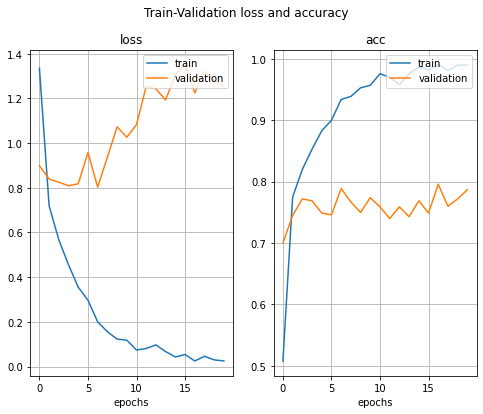

In [ ]:
import matplotlib.pyplot as plt

     
plt.figure(figsize=(8,6))
plt.subplot(1, 2, 1)
plt.plot(loss_x,label="train")
plt.plot(loss_y,label="validation")
plt.title('loss')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('')
plt.grid(loss_x)

plt.subplot(1, 2, 2)
plt.plot(acc_x,label="train")
plt.plot(acc_y,label="validation")
plt.title('acc')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('')
plt.grid(acc_x)

plt.suptitle("Train-Validation loss and accuracy")

plt.show()


We'll load up the parameters that gave us the best validation loss and try these on the test set - which gives us our best results so far!

In [ ]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.305 | Test Acc: 91.69%


## Inference

We'll then use the model to test the sentiment of some sequences. We tokenize the input sequence, trim it down to the maximum length, add the special tokens to either side, convert it to a tensor, add a fake batch dimension and then pass it through our model.

In [ ]:
categories=['emotional','work','relationship','friendship','school','others','family']

In [ ]:
def predict_sentiment(model, tokenizer, sentence):
    model.eval()
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    indexed = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_idx]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))
    index = torch.argmax(prediction)
    label = categories[index.cpu().numpy()]
    return label

In [ ]:
predict_sentiment(model, tokenizer, "I have totally a bad day")

'others'

In [ ]:
y_train[:10]

1143            work
1053    relationship
372             work
826             work
840        emotional
776        emotional
778     relationship
1076    relationship
887        emotional
1125       emotional
Name: problem_type, dtype: object

In [ ]:
text_train[:10]

1143    I made a mistake at work and I feel I might ge...
1053    Husband of 9 years walked out on me and our ch...
372     My boss recently left the company and I am not...
826     my boss does not care about my and there is no...
840                                          I was fired.
776     when i lost my job and i was at home for long ...
778     I recently broke up with my boyfriend and I'm ...
1076    My ex who i loved so much and almost gave her ...
887     I have been in a depression since my father di...
1125    I am sad about not having family near me. I am...
Name: situation, dtype: object

In [ ]:
situation = []
i=0
for t in text_train[:10]:
  situation.append(predict_sentiment(model, tokenizer, t))
  
situation

['work',
 'relationship',
 'work',
 'work',
 'work',
 'work',
 'relationship',
 'relationship',
 'emotional',
 'emotional']

# BERT Inference

In [ ]:
from transformers import BertTokenizer, BertModel

bert = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import torch.nn as nn

class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(text)[0]
                
        #embedded = [batch size, sent len, emb dim]
        
        _, hidden = self.rnn(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output

Next, we create an instance of our model using standard hyperparameters.

In [ ]:
HIDDEN_DIM = 256
OUTPUT_DIM = 7
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25
max_input_length = 512

model = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

In [ ]:
model.load_state_dict(torch.load("tut6-model.pt"))

<All keys matched successfully>

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

Next, we'll define functions for: calculating accuracy, performing a training epoch, performing an evaluation epoch and calculating how long a training/evaluation epoch takes.

In [ ]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    # correct.to(device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    return correct.sum() / len(correct)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
      for batch in iterator:
  
          
          predictions = model(batch.text).squeeze(1)
          
          loss = criterion(predictions, batch.label)
          
          acc = categorical_accuracy(predictions, batch.label)
          

          
          epoch_loss += loss.item()
          epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

## Inference

We'll then use the model to test the sentiment of some sequences. We tokenize the input sequence, trim it down to the maximum length, add the special tokens to either side, convert it to a tensor, add a fake batch dimension and then pass it through our model.

In [ ]:
categories=['emotional','work','relationship','friendship','school','others','family']

In [ ]:
def predict_sentiment(model, tokenizer, sentence):
    model.eval()
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    indexed = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_idx]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))
    index = torch.argmax(prediction)
    label = categories[index.cpu().numpy()]
    return label

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
predict_sentiment(model, tokenizer, "I have totally a bad day")

'others'